In [ ]:
## importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## importing the dataset
data = pd.read_csv('/content/drive/MyDrive/Deep Learning/Predict the movement of a person/map_data.csv',index_col='id',usecols=['id','Latitude','Longitude'])

In [ ]:
## sample data
data.head()

Longitude   Latitude
id                      
1  -99.711318  32.470813
2  -99.711345  32.467800
3  -99.704908  32.470813
4  -99.705004  32.467800
5  -99.711200  32.468212

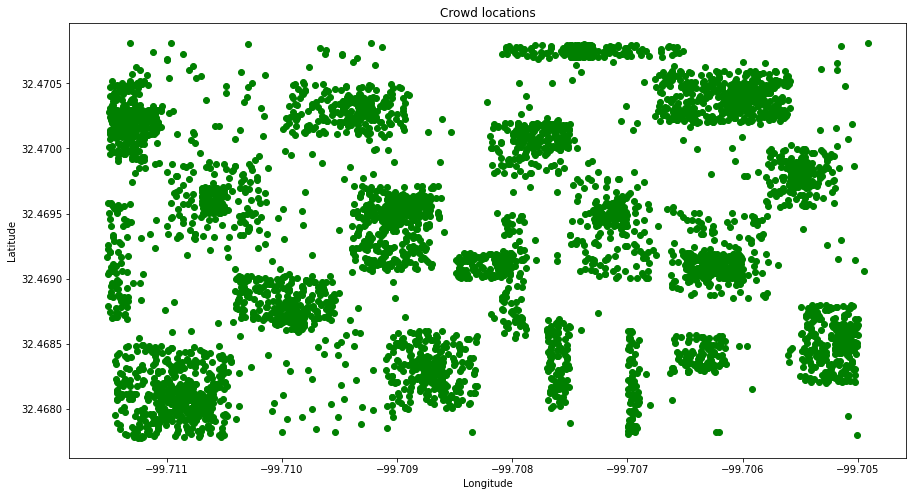

In [ ]:
## plotting the locations
plt.figure(figsize=(15,8))
plt.scatter(data=data,x='Longitude',y='Latitude',color='green')
plt.title('Crowd locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
## Performing K-Means clustering
## importing the KMeans library
from sklearn.cluster import KMeans

## initializing the Kmeans with 16 clusters
km = KMeans(n_clusters=16)

## Fitting the model for dataset
data['cluster'] = km.fit_predict(data)

In [ ]:
data.to_csv('/content/drive/MyDrive/Deep Learning/Predict the movement of a person/data_cluster.csv')

In [ ]:
import pickle
pickle_out = open('/content/drive/MyDrive/Deep Learning/Predict the movement of a person/K_means.pkl','wb')
pickle.dump(km,pickle_out)
pickle_out.close()

***Importing the K-means and clustered data***

In [ ]:
### importing the clustered data
data = pd.read_csv('/content/drive/MyDrive/Deep Learning/Predict the movement of a person/data_cluster.csv',index_col='id')
print(data.head())
print(data.shape)

    Longitude   Latitude  cluster
id                               
1  -99.711318  32.470813        3
2  -99.711345  32.467800        4
3  -99.704908  32.470813        5
4  -99.705004  32.467800        0
5  -99.711200  32.468212        4
(5034, 3)


In [ ]:
### importing cluster algorithm
import pickle
cl = pickle.load(open('/content/drive/MyDrive/Deep Learning/Predict the movement of a person/K_means.pkl','rb'))
print(cl)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=10, n_jobs='deprecated',
       precompute_distances='deprecated', random_state=None, tol=0.0001,
       verbose=0)


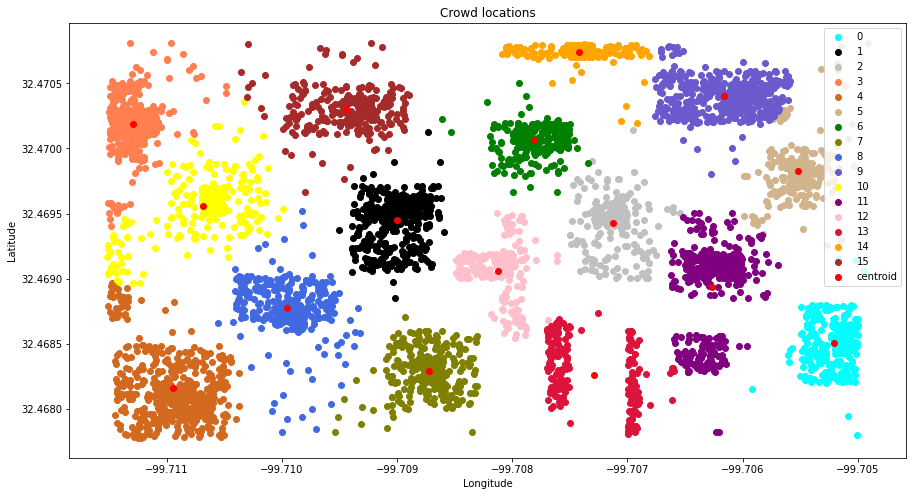

In [ ]:
## Fixing the size of the plot
plt.figure(figsize=(15,8))

## fixing the color for clusters
colors = ['aqua','black','silver','coral','chocolate','tan','green','olive','royalblue','slateblue','yellow',
          'purple','pink','crimson','orange','brown']

## plotting the clusters 
for i in range(0,16):
    plt.scatter(data.Longitude[data.cluster==i] , data.Latitude[data.cluster==i] , label = i,color=colors[i])

## Plotting the centroid of the clusters
plt.scatter(x=cl.cluster_centers_[:,0],y=cl.cluster_centers_[:,1],color='red',label='centroid')
plt.title('Crowd locations')
plt.xlabel('Longitude')
plt.legend()
plt.ylabel('Latitude')
plt.show()

In [ ]:
## creating the dataset to apply timestamping
## creating the empty library
#timestamp = pd.DataFrame()

## selecting the 60 records from each cluster
#for i in range(0,16):
    #timestamp = timestamp.append(data[data.cluster==i].head(60))
    
## exporting the data
#timestamp.to_csv('cluster_data.csv')

In [ ]:
## reading the timestamp data
t_data = pd.read_csv('/content/drive/MyDrive/Deep Learning/Predict the movement of a person/cluster_data.csv')
t_data.head()

id  Longitude   Latitude  cluster  Timestamp_1  Timestamp_2
0   4 -99.705004  32.467800        0           11            5
1  28 -99.705919  32.468153        0           11            5
2  31 -99.705589  32.468453        0           11            5
3  53 -99.704948  32.469056        0           11            5
4  66 -99.705084  32.467947        0           11            5

In [ ]:
x=[];y=[]
for i in range(0,len(t_data)):
    x.append([t_data.cluster[i],t_data.Timestamp_1[i]])
    y.append([t_data.Timestamp_1[i],t_data.Timestamp_2[i]])

In [ ]:
X = np.array(x).reshape(960, 1, 2)
print(X.shape)
X[:5]

(960, 1, 2)


array([[[ 0, 11]],

       [[ 0, 11]],

       [[ 0, 11]],

       [[ 0, 11]],

       [[ 0, 11]]])

In [ ]:
Y = np.array(y)
print(Y.shape)
Y[:5]

(960, 2)


array([[11,  5],
       [11,  5],
       [11,  5],
       [11,  5],
       [11,  5]])

In [ ]:
## importing the libraries to train LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
## padding the input and output values
#x = pad_sequences(x,maxlen=3)
#y = pad_sequences(y,maxlen=3)

In [ ]:
## creating the training dataset
#train_data = tf.data.Dataset.from_tensor_slices((x,y))

In [ ]:
## initializing the model
model = Sequential()

model.add(LSTM(128, activation='relu', input_shape=(None,2), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu',name='Hidden'))
model.add(Dropout(0.2))
model.add(Dense(2,name='Output'))

opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

model.compile(optimizer=opt,
              loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         67072     
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
Hidden (Dense)               (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 2)                 1

In [ ]:
## Fitting for train data
model.fit(X,Y, epochs=1000,batch_size=64)

Epoch 1/1000
15/15 [==============================] - 24s 14ms/step - loss: 75.5586
Epoch 2/1000
15/15 [==============================] - 0s 12ms/step - loss: 54.0235
Epoch 3/1000
15/15 [==============================] - 0s 12ms/step - loss: 27.8280
Epoch 4/1000
15/15 [==============================] - 0s 13ms/step - loss: 20.8039
Epoch 5/1000
15/15 [==============================] - 0s 13ms/step - loss: 17.8443
Epoch 6/1000
15/15 [==============================] - 0s 13ms/step - loss: 15.8907
Epoch 7/1000
15/15 [==============================] - 0s 12ms/step - loss: 14.6140
Epoch 8/1000
15/15 [==============================] - 0s 13ms/step - loss: 13.6564
Epoch 9/1000
15/15 [==============================] - 0s 13ms/step - loss: 12.7293
Epoch 10/1000
15/15 [==============================] - 0s 12ms/step - loss: 11.6228
Epoch 11/1000
15/15 [==============================] - 0s 13ms/step - loss: 11.2906
Epoch 12/1000
15/15 [==============================] - 0s 13ms/step - loss: 11.2919


In [ ]:
## testing for new data
test_input = np.array([[0,5]])

test_input = test_input.reshape((1, 1, 2))
test_output = model.predict(test_input, verbose=0)
int(np.round(test_output[0][1],0))

9

***Plotting movement of a person based on the distance to the cluster***

In [ ]:
## defining a function to plot the test person location
image = plt.imread('/content/drive/MyDrive/Deep Learning/Predict the movement of a person/map.png')
def locate_me(point):
    plt.figure(figsize=(20,12))
    plt.imshow(image,extent=[-99.7116,-99.704908,32.4676,32.4709])    ##fixing size of the graph
    plt.scatter(data=data,x='Longitude',y='Latitude',color='yellow',label='Crowd location')
    plt.scatter(x=point[0], y=point[1],color='red',marker='*',s=200,label='Person Location')
    plt.title('Crowd')
    plt.xlabel('Longitude')
    plt.legend()
    plt.ylabel('Latitude')
    plt.show()

In [ ]:
## Defining a function to track the person movement based on distance to the cluster
def movement(point):
    z = cl.predict([point])   ## mapping new location with the cluster
    point1 = cl.cluster_centers_[int(z)]    ## centroid of the mapped cluster
    dx = (point1[0]-point[0])*0.8
    dy = (point1[1]-point[1])*0.8
    plt.figure(figsize=(20,12))
    plt.imshow(image,extent=[-99.7116,-99.704908,32.4676,32.4709])
    plt.scatter(data=data,x='Longitude',y='Latitude',color='yellow',label='Crowd location')     ## plotting the crowd locations
    plt.scatter(x=point[0], y=point[1],color='red',marker='*',s=300,label='Person Location')    ## plotting the person previous location
    plt.scatter(x=point1[0], y=point1[1],color='red',marker='+',s=300,label='New Location')    ## plotting the person new location
    plt.arrow(point[0],point[1],dx,dy,width=0.000008,head_width=0.00007,label='movement')
    plt.title('Crowd')
    plt.xlabel('Longitude')
    plt.legend()
    plt.ylabel('Latitude')
    plt.show()
    plt.show()

In [ ]:
## Defining function to track movement using LSTM
def track(point,new_point):
    z = cl.predict([point])   ## mapping new location with the cluster
    point1 = cl.cluster_centers_[int(z)]    ## centroid of the mapped cluster
    dx = (point1[0]-point[0])*0.9
    dy = (point1[1]-point[1])*0.9

    z1 = cl.predict([new_point])   ## mapping 2nd location with the cluster
    point2 = cl.cluster_centers_[int(z1)]
    dx1 = (point2[0]-point1[0])*0.85
    dy1 = (point2[1]-point1[1])*0.85

    new = np.array([[int(z),int(z1)]])
    test_input = new.reshape((1, 1, 2))
    test_output = model.predict(test_input, verbose=0)    ## predicting using LSTM model

    loc = int(np.round(test_output[0][1],0))
  
    point3 = cl.cluster_centers_[loc]     ## centroid of predicted location
    dx2 = (point3[0]-point2[0])*0.85
    dy2 = (point3[1]-point2[1])*0.85

    plt.figure(figsize=(20,12))
    plt.imshow(image,extent=[-99.7116,-99.704908,32.4676,32.4709])    ## fixing the image dimesion

    ## plotting the crowd locations
    plt.scatter(data=data,x='Longitude',y='Latitude',color='yellow',label='Crowd location') 

    ## plotting the person previous location
    plt.scatter(x=point[0], y=point[1],color='red',marker='*',s=200,label='Person Location')

    ## plotting the person initial location to cluster
    plt.scatter(x=point1[0], y=point1[1],color='red',marker='o',s=100)    
    plt.arrow(point[0],point[1],dx,dy,width=0.000008,head_width=0.00007,label='movement')

    ## plotting 2nd location of the person
    plt.scatter(x=point2[0], y=point2[1],color='red',marker='+',s=250,label='2nd Location')    
    plt.arrow(point1[0],point1[1],dx1,dy1,width=0.000008,head_width=0.00007)

    ## plotting the predicted location
    plt.scatter(x=point3[0], y=point3[1],color='green',marker='o',s=350,label='Predicted location')
    plt.arrow(point2[0],point2[1],dx2,dy2,width=0.000008,head_width=0.00007,color='blue')
    plt.title('Crowd')
    plt.xlabel('Longitude')
    plt.legend()
    plt.ylabel('Latitude')
    plt.show()
    plt.show()

In [ ]:
## test point
point = [-99.7085, 32.470]

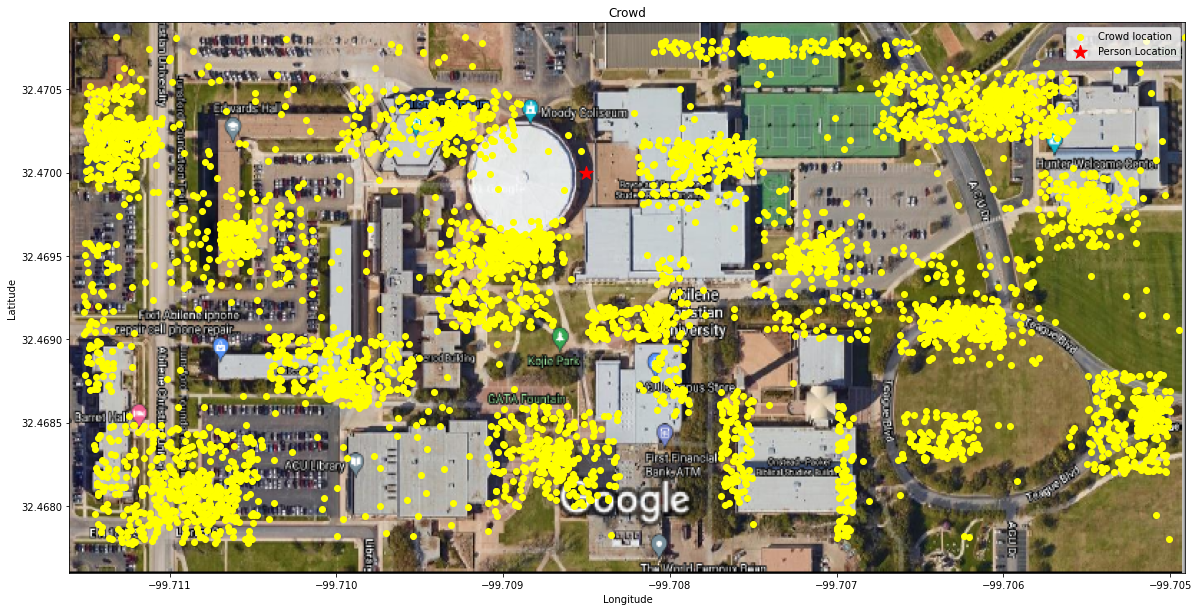

In [ ]:
## checking the location
locate_me(point)

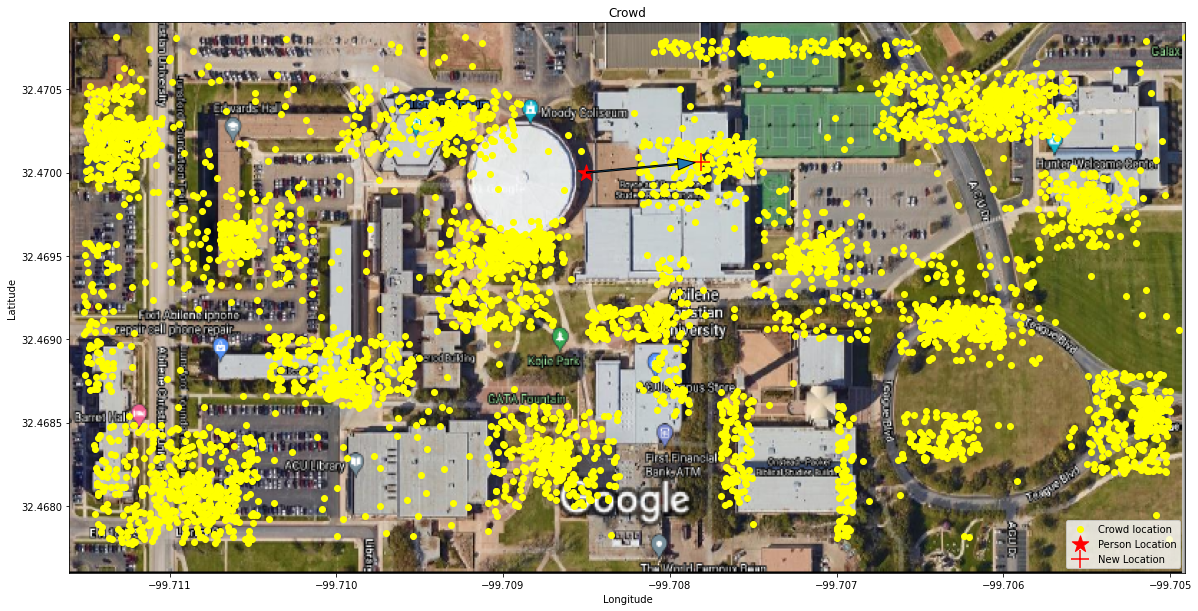

In [ ]:
## Predicting the movement of the person
movement(point)

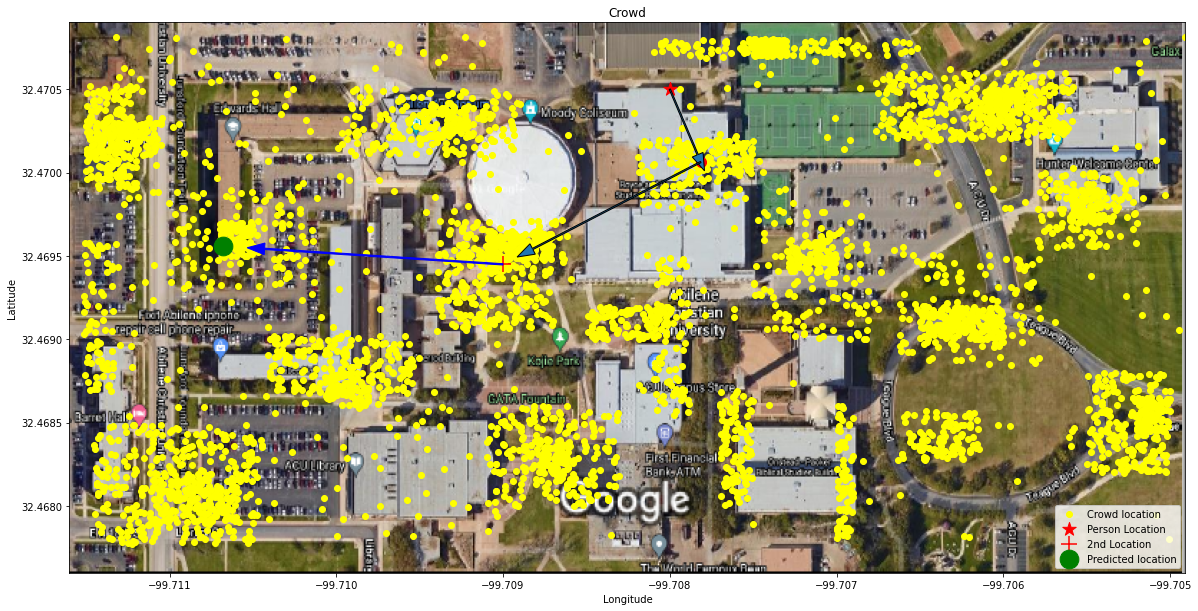

In [ ]:
point = [-99.708,32.4705]
point1 = [-99.7085,32.4695]
track(point,point1)